# Image Denoising with RBF Regression and KMeans Clustering

This notebook is to discover the application of RBF Regression and Kmeans Clustering in image denoising. The input images are corrupted by salt-and-pepper noise. Then the clean pixels with be clustered by KMeans Clustering with spatial and colour features. The cluster centers and widths will then be used for RBF Regression to fill the corrupted pixels.

Start with the initial imports. 

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from kneed import KneeLocator
from scipy.spatial.distance import cdist

### RBF Regression

Then a class `RBFRegression` is defined with the following attributes:
- `centers`:
- `widths`:
- `K`:
- `parameters`:

And has the following functions:
- `rbf_2d`:
- `predict`:
- `fit_with_l2_regularization(self, train_X, train_Y, l2_coeff)`:

In [3]:
class RBFRegression():
    def __init__(self, centers, widths):
        """ This class represents a radial basis function regression model.
        Given a single scalar input x,
        f(x) = b + w_1 * b_1(x) + w_2 * b_2(x) + ... + w_K * b_K(x), 
        where b_i is the i'th radial basis function.

        args:
            - centers (ndarray (Shape: (K, 2))): 
                A Kx2 matrix corresponding to the centers of the 2D radial basis functions.
            - widths (ndarray (Shape: (K, 1))): 
                A K-column vector corresponding to the widths of the radial basis functions.
        """
        assert centers.shape[0] == widths.shape[0], f"The number of centers and widths must match. (Centers: {centers.shape[0]}, Widths: {widths.shape[0]})"
        assert centers.shape[1] == 2, f"Each center should have two components. (Centers: {centers.shape[1]})"
        assert widths.shape[1] == 1, f"Each width should have one component. (Widths: {widths.shape[1]})"
        self.centers = centers
        self.widths = widths
        self.K = centers.shape[0]

        # Remember that we have K weights and 1 bias.
        self.parameters = np.ones((self.K + 1, 1), dtype=np.float32)

    def rbf_2d(self, X, i):
        """ This method computes the output of the i'th 2D radial basis function given the inputs.
        Recall that RBF(x) = exp(-||x - center||^2 / (2 * width^2))

        args:
            - X (ndarray (Shape: (N, 2))): A Nx2 matrix consisting N 2D input data.
            - i (int): The i'th radial basis function.

        output:
            - z ndarray (Shape: (N, 1)): A N-column vector consisting N scalar output data.
        """
        assert 1 <= i <= self.K

        # Retrieve the center and the width of the radial basis function
        rbf_center = self.centers[[i-1]]
        rbf_width = self.widths[[i-1]]

        # Use the selected center and width to compute the RBF
        distance = np.linalg.norm(X - rbf_center, axis=1, keepdims=True)
        rbf_out = np.exp(-distance**2 / (2 * (rbf_width**2)))
        
        return rbf_out

    def predict(self, X):
        """ This method predicts the output of the given input data using the model parameters. 

        args:
            - X (ndarray (Shape: (N, 2))): A Nx2 matrix consisting N 2D input data.

        output:
            - ndarray (shape: (N, 1)): A N-column vector consisting N scalar output data.

        NOTE: You must not iterate through inputs. HINT: You can use self.rbf_2d to compute b_i(X).
        """
        assert X.shape[1] == 2, f"Each input should contain two components. Got: {X.shape[1]}"

        # Use rbf_2d function to compute each radial basis function at X inputs and then sum them all. 
        Z = np.zeros((X.shape[0], self.K))
        for i in range(1, self.K + 1):
            Z[:, i - 1] = self.rbf_2d(X, i).flatten()
        Z = np.hstack((np.ones((X.shape[0], 1)), Z))
        prediction = Z @ self.parameters

        return prediction
    
    def fit_with_l2_regularization(self, train_X, train_Y, l2_coeff):
        """ This method fits the model parameters, given the training inputs and outputs.
        This method does not have output. You only need to update self.parameters.

        args:
            - train_X (ndarray (shape: (N, 2))): A Nx2 matrix consisting N 2D training inputs.
            - train_Y (ndarray (shape: (N, 1))): A N-column vector consisting N scalar training outputs.
            - l2_coeff (float): The lambda term that decides how much regularization we want.

        NOTE: Review from notes the least squares solution with l2 regularization.
        """
        assert train_X.shape[0] == train_Y.shape[0], f"Number of inputs and outputs are different. (train_X: {train_X.shape[0]}, train_Y: {train_Y.shape[0]})"
        assert train_X.shape[1] == 2, f"Each input should contain two components. Got: {train_X.shape[1]}"
        assert train_Y.shape[1] == 1, f"Each output should contain 1 component. Got: {train_Y.shape[1]}"

        # Set self.parameters to regularized least square solution for the radial basis function
        B = np.zeros((train_X.shape[0], self.K))
        for i in range(1, self.K + 1):
            B[:, i - 1] = self.rbf_2d(train_X, i).flatten()
        B = np.hstack((np.ones((train_X.shape[0], 1)), B))

        I = np.identity(self.K + 1)
        I[0, 0] = 0.0
        scaled_matrix = l2_coeff * I

        self.parameters = np.linalg.inv(B.T @ B + scaled_matrix) @ B.T @ train_Y

        assert self.parameters.shape == (self.K + 1, 1)

### Load Image

In [4]:
# Read the Image
image_name = './cherry_blossom.png'
img = Image.open(image_name)
img = img.resize((img.size[0] // 2, img.size[1] // 2))
img = np.array(img) / 255 
img = img.astype(np.float32)

### Salt-and-pepper noise

In [5]:
pepper_rgb = np.array([0, 0, 0])
pepper_rgb = pepper_rgb.astype(np.float32) / 255
salt_rgb = np.array([255, 255, 255])
salt_rgb = salt_rgb.astype(np.float32) / 255

def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = np.copy(image)
    
    # Add salt noise
    salt_pixels = np.random.rand(*image.shape[:-1]) < salt_prob
    noisy_image[salt_pixels] = 1

    # Add pepper noise
    pepper_pixels = np.random.rand(*image.shape[:-1]) < pepper_prob
    noisy_image[pepper_pixels] = 0

    return noisy_image

noisy_img = add_salt_and_pepper_noise(img, 0.2, 0.2)

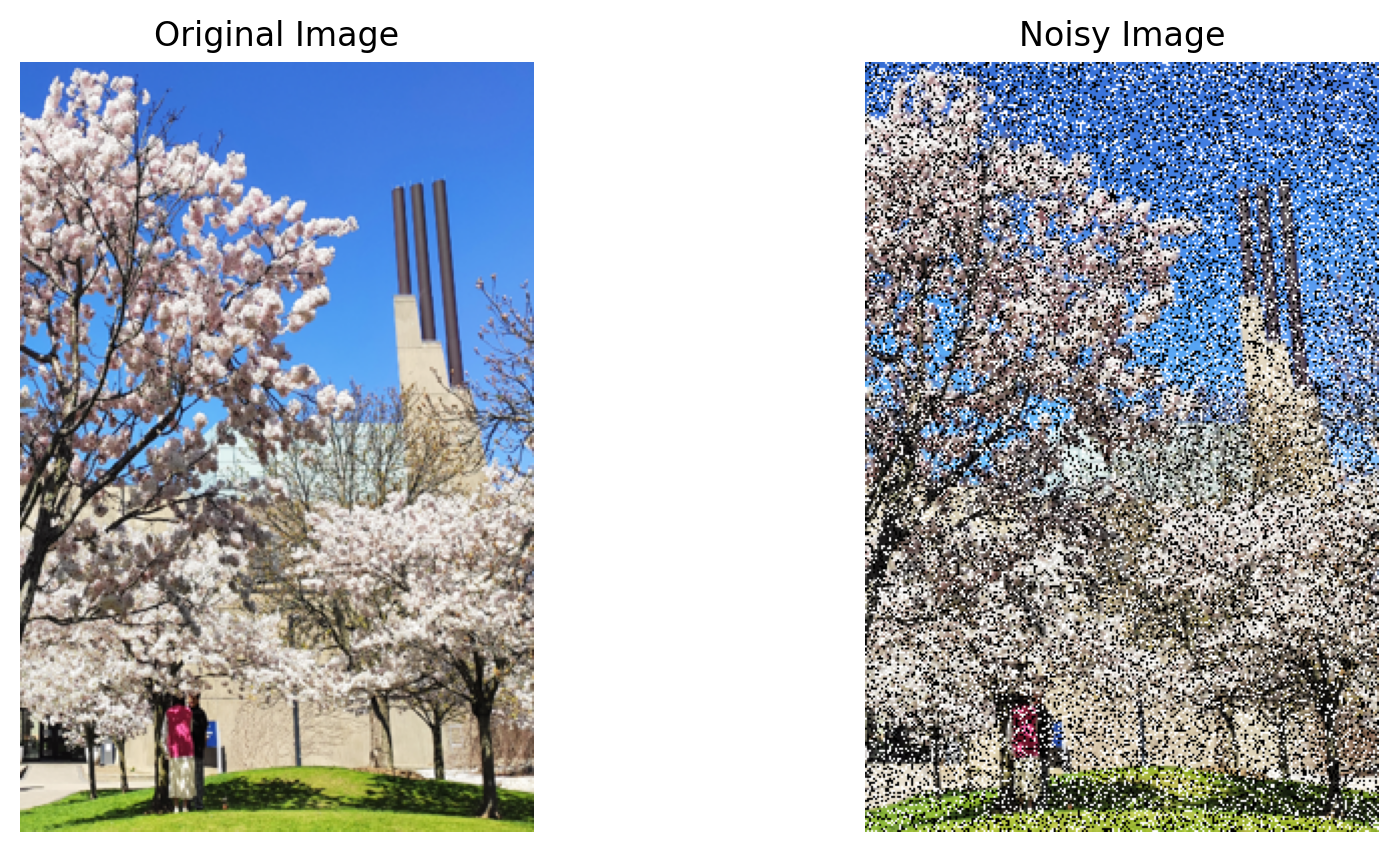

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[1].imshow(noisy_img)
axs[1].set_title('Noisy Image')
axs[0].set_axis_off()
axs[1].set_axis_off()
plt.show()

### Image denoising with KMeans Clustering on spatial features only

In [7]:
def denoising_with_clustering(im, l2_coeff, max_K):
    im_rec = im.copy() # reconstruction or denoised
    H, W = im.shape[:2]

    reshaped_img = im.reshape(-1, 3)
    coords = np.array([(i // W, i % W) for i in range(H * W)]) 

    # Find clean pixels
    salt_mask = np.all(reshaped_img == salt_rgb, axis=1)
    pepper_mask = np.all(reshaped_img == pepper_rgb, axis=1)
    clean_mask = ~(salt_mask | pepper_mask)
    fill_mask = (salt_mask | pepper_mask)

    # Coordinates of clean pixels
    clean_coords = coords[clean_mask]
    fill_coords = coords[fill_mask]

    if len(clean_coords) == 0:
        raise ValueError("No clean pixels found to cluster.")
    
    idx_data = clean_coords[:,0] * W + clean_coords[:,1]
    idx_fill = fill_coords[:,0] * W + fill_coords[:,1]

    # Elbow method find optimal K
    wcss = []
    Ks = range(1, max_K + 1)
    for K in Ks:
        km = KMeans(n_clusters=K, n_init=10)
        km.fit(clean_coords) # Fit KMeans model with spatial features
        wcss.append(km.inertia_)
    
    # Find optimal K with KneeLocator
    kn = KneeLocator(Ks, wcss, curve='convex', direction='decreasing')
    optimal_K = kn.knee
    if optimal_K is None:
        optimal_K = 20  # fallback

    print(f"The optimal K value is: {optimal_K}")

    # Fit KMeans model to clean pixels with optimal K
    kmeans = KMeans(n_clusters=optimal_K, n_init=10)
    kmeans.fit(clean_coords)
    centers = kmeans.cluster_centers_
    num_centers = centers.shape[0]

    # Find widths by the distance of the nearest cluster's center
    dist_matrix = cdist(centers, centers)
    np.fill_diagonal(dist_matrix, np.inf)
    widths = np.min(dist_matrix, axis=1).reshape(-1,1)

    if optimal_K == 1:
        widths[:] = max(H, W) / 2.0
    
    # Construct one model for each color channel
    red_model = RBFRegression(centers=centers, widths=widths)
    green_model = RBFRegression(centers=centers, widths=widths)
    blue_model = RBFRegression(centers=centers, widths=widths)
    
    if (idx_fill.size>0):
        if(idx_data.size <= num_centers):
            pass
        else:
            # Reconstruct each colour layer using a separate RBF model

            # Red channel
            im_R = im[:,:,0]
            z_R = im_R.reshape(im_R.size, 1, order='C')
            z_R = z_R[idx_data]
            red_model.fit_with_l2_regularization(clean_coords, z_R, l2_coeff)

            # Green channel
            im_G = im[:,:,1]
            z_G = im_G.reshape(im_G.size, 1, order='C')
            z_G = z_G[idx_data]
            green_model.fit_with_l2_regularization(clean_coords, z_G, l2_coeff)
            
            # Blue channel
            im_B = im[:,:,2]
            z_B = im_B.reshape(im_B.size, 1, order='C')
            z_B = z_B[idx_data]
            blue_model.fit_with_l2_regularization(clean_coords, z_B, l2_coeff)

            # Reconstruct pixel values at fill-in locations
            fill_R = red_model.predict(fill_coords)
            fill_G = green_model.predict(fill_coords)
            fill_B = blue_model.predict(fill_coords)

            # Assemble reconstructed image
            im_rec[fill_coords[:,0], fill_coords[:,1], 0] = np.squeeze(np.asarray(fill_R)) # Red
            im_rec[fill_coords[:,0], fill_coords[:,1], 1] = np.squeeze(np.asarray(fill_G)) # Green
            im_rec[fill_coords[:,0], fill_coords[:,1], 2] = np.squeeze(np.asarray(fill_B)) # Blue
    else:
        pass
    im_rec = np.clip(im_rec, 0, 1)
    return im_rec

In [8]:
# Chosen hyperparameters
l2_coef = 0.1
max_K = 30
# Obtain denoised image
img_rec = denoising_with_clustering(noisy_img, l2_coeff=l2_coef, max_K=max_K)

The optimal K value is: 6


In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5), dpi=200)
axs[0].imshow(img)
axs[1].imshow(noisy_img)
axs[2].imshow(img_rec)
axs[0].set_axis_off()
axs[1].set_axis_off()
axs[2].set_axis_off()
plt.show()

### Image denoising with KMeans Clustering with spatial and colour features